In [8]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# dataset_path = "G://My Drive//dataset//split_data"
dataset_path = "./split_dataset"

In [10]:
input_size = 128
batch_size_num = 32
train_path = os.path.join(dataset_path, "train")


train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(input_size, input_size),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size_num,
    shuffle=True,
)

Found 14000 images belonging to 2 classes.


In [11]:
val_path = os.path.join(dataset_path, "val")

val_datagen = ImageDataGenerator(rescale=1 / 255)

val_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(input_size, input_size),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size_num,
    shuffle=True,
)

Found 1700 images belonging to 2 classes.


In [12]:
xception_model = tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


model = Sequential()
model.add(xception_model)
model.add(Dense(units=512, activation="ReLU"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="ReLU"))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation="ReLU"))
model.add(Dense(units=1, activation="sigmoid"))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1000)              22910480  
                                                                 
 dense_4 (Dense)             (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [13]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [14]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath = ".\\tmp_checkpoint"
print("Creating Directory: " + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

custom_callbacks = [
    EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_filepath, "best_model.h5"),
        monitor="val_loss",
        mode="min",
        verbose=1,
        save_best_only=True,
    ),
]

# Train network
num_epochs = 10
history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=custom_callbacks,
)

Creating Directory: .\tmp_checkpoint
Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6989
Epoch 1: val_loss improved from inf to 0.54872, saving model to .\tmp_checkpoint\best_model.h5
438/438 [==============================] - 3173s 7s/step - loss: 0.6299 - accuracy: 0.6989 - val_loss: 0.5487 - val_accuracy: 0.7565
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7958
Epoch 2: val_loss improved from 0.54872 to 0.37667, saving model to .\tmp_checkpoint\best_model.h5
438/438 [==============================] - 3141s 7s/step - loss: 0.4774 - accuracy: 0.7958 - val_loss: 0.3767 - val_accuracy: 0.8282
Epoch 3/10
438/438 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8625
Epoch 3: val_loss improved from 0.37667 to 0.25434, saving model to .\tmp_checkpoint\best_model.h5
438/438 [==============================] - 3132s 7s/step - loss: 0.3312 - accuracy: 0.8625 - val_loss: 0.2543 - val_

In [15]:
checkpoint_filepath = ".\\tmp_checkpoint"
best_model = load_model(os.path.join(checkpoint_filepath, "best_model.h5"))
best_model.save("best_model.h5")

In [16]:
best_model.evaluate(train_generator)

438/438 [==============================] - 783s 2s/step - loss: 0.0458 - accuracy: 0.9856


[0.04581044241786003, 0.9856428503990173]

In [17]:
best_model.evaluate(val_generator)

54/54 [==============================] - 89s 2s/step - loss: 0.1232 - accuracy: 0.9512


[0.12324687093496323, 0.9511764645576477]

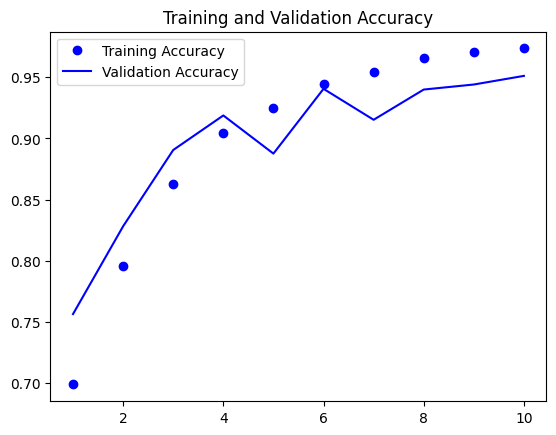

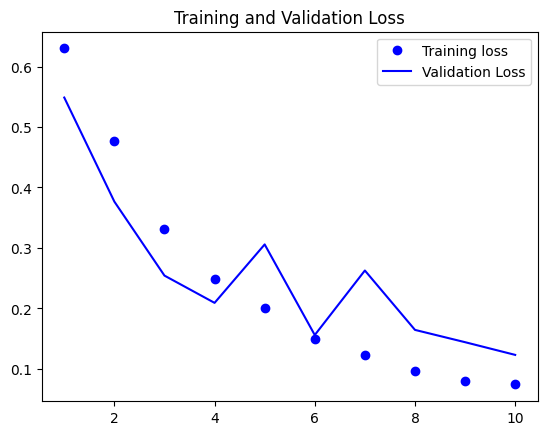

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [19]:
test_path = os.path.join(dataset_path, "test")
test_datagen = ImageDataGenerator(rescale=1 / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    classes=["fake", "real"],
    target_size=(input_size, input_size),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    shuffle=False,
)

Found 1697 images belonging to 2 classes.


1697/1697 [==============================] - 189s 111ms/step
                 Filename  Prediction
0     fake\06A15B1TUD.jpg    0.001173
1     fake\06A30XHW61.jpg    0.002569
2     fake\06B3SMWZIJ.jpg    0.007412
3     fake\06BFJD4I2R.jpg    0.017249
4     fake\06C7XL8XNS.jpg    0.000057
...                   ...         ...
1692       real\01732.jpg    0.997675
1693       real\01733.jpg    0.998465
1694       real\01734.jpg    0.998232
1695       real\01735.jpg    0.998454
1696       real\01736.jpg    0.991627

[1697 rows x 2 columns]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[[804  43]
 [ 42 808]]


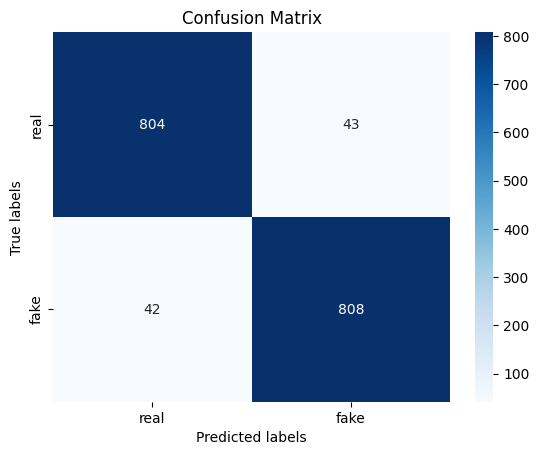

In [20]:
test_generator.reset()

prediction = best_model.predict(test_generator, verbose=1)

test_results = pd.DataFrame(
    {"Filename": test_generator.filenames, "Prediction": prediction.flatten()}
)
print(test_results)

# confusion matrix


y_true = test_generator.classes
print(y_true)
y_pred = np.array([0 if pred < 0.5 else 1 for pred in prediction.flatten()])
print(y_pred)
cm = confusion_matrix(y_true, y_pred)
print(cm)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")

ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["real", "fake"])

ax.yaxis.set_ticklabels(["real", "fake"])

plt.show()

In [21]:
# classification report

print(classification_report(y_true, y_pred, target_names=["real", "fake"]))

              precision    recall  f1-score   support

        real       0.95      0.95      0.95       847
        fake       0.95      0.95      0.95       850

    accuracy                           0.95      1697
   macro avg       0.95      0.95      0.95      1697
weighted avg       0.95      0.95      0.95      1697

